<a href="https://colab.research.google.com/github/Uzair-DeVops/Deep_Learing_Projects_Computer_Vision/blob/main/FER_USING_GNN_1ST_ATTEMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision
!pip install torch-geometric
!pip install dlib opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [129]:
import cv2
import dlib
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool


# STEP  01
## load dlib model and detect_landmarks from the image

In [127]:
# Load dlib models
# Loading the face detector and shape predictor This initializes dlib’s HOG‑based frontal face detector and loads the 68‑point landmark model from disk. In other words, we’re arming our code with the power to find faces and then poke 68 little “landmarks” on them—like sticking pins in a voodoo doll, but way friendlier!
detector = dlib.get_frontal_face_detector()

# DOWNLOAD USING THIS LINK https://github.com/italojs/facial-landmarks-recognition/blob/master/shape_predictor_68_face_landmarks.dat
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

def detect_landmarks(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detector(gray, 1)
    if not faces:
        return None, img
    shape = predictor(gray, faces[0])
    lm = np.array([[p.x, p.y] for p in shape.parts()], dtype=np.float32)
    return lm, img


In [130]:
landmarks, img = detect_landmarks('neutral.jpg')


#02 divide the region


In [131]:
def divide_regions(landmarks):
    xs, ys = landmarks[:,0], landmarks[:,1]
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    w, h = x_max - x_min, y_max - y_min
    y1, y2 = y_min + h/3, y_min + 2*h/3
    x_mid = x_min + w/2

    regions = [
        ((x_min, x_mid), (y_min, y1)),  # Q1: upper-left
        ((x_mid, x_max), (y_min, y1)),  # Q2: upper-right
        ((x_min, x_mid), (y1, y2)),     # Q3: upper-middle-left
        ((x_mid, x_max), (y1, y2)),     # Q4: upper-middle-right
        ((x_min, x_max), (y1, y2)),     # Q5: middle
        ((x_min, x_max), (y2, y_max)),  # Q6: lower
    ]
    return regions


In [132]:
divide_regions(landmarks)

[((165.0, 196.5), (78.0, 98.66666666666667)),
 ((196.5, 228.0), (78.0, 98.66666666666667)),
 ((165.0, 196.5), (98.66666666666667, 119.33333333333334)),
 ((196.5, 228.0), (98.66666666666667, 119.33333333333334)),
 ((165.0, 228.0), (98.66666666666667, 119.33333333333334)),
 ((165.0, 228.0), (119.33333333333334, 140.0))]

# 03 Step select node from each region

In [133]:
def select_nodes_per_region(landmarks, regions, ratios=[2,2,2,2,3,7]):
    selected = []
    for (x_rng,y_rng), r in zip(regions, ratios):
        # mask points inside region
        mask = (landmarks[:,0] >= x_rng[0]) & (landmarks[:,0] <= x_rng[1]) & \
               (landmarks[:,1] >= y_rng[0]) & (landmarks[:,1] <= y_rng[1])
        pts = landmarks[mask]
        if len(pts)==0:
            continue
        # compute distance to region center
        cx, cy = np.mean(x_rng), np.mean(y_rng)
        dists = np.linalg.norm(pts - np.array([cx,cy]), axis=1)
        # pick r closest
        idx = np.argsort(dists)[:r]
        selected.append(pts[idx])
    return np.vstack(selected)  # shape: [N,2]


In [134]:
nodes = select_nodes_per_region(landmarks, divide_regions(landmarks))

# Build Graph

In [135]:
def build_graph(nodes):
    N = len(nodes)
    # node features = raw (x,y)
    x = torch.tensor(nodes, dtype=torch.float)

    # edges: all pairs (i,j), i<j
    edge_index = []
    edge_attr = []
    for i in range(N):
        for j in range(i+1, N):
            edge_index.append([i,j])
            edge_index.append([j,i])
            # weight = exp(-d) or 1/d
            d = np.linalg.norm(nodes[i]-nodes[j])
            w = 1.0/(d+1e-6)
            edge_attr += [w, w]
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)


In [136]:
data =build_graph(nodes)
data

Data(x=[18, 2], edge_index=[2, 306], edge_attr=[306])

# Plot Graph

In [137]:
import numpy as np
import matplotlib.pyplot as plt

def plot_graph(x, edge_index, edge_attr):
    """
    Plot a graph given node coordinates and edge data.

    Args:
        x           : array-like, shape [N, 2]       Node (x,y) coordinates
        edge_index  : array-like, shape [2, E]       Pairs of node indices defining edges
        edge_attr   : array-like, shape [E]          Weight for each directed edge
    """
    x = np.array(x)
    edge_index = np.array(edge_index)
    edge_attr = np.array(edge_attr)
    plt.figure(figsize=(6, 6))

    # Draw edges (only plot each undirected edge once i<j)
    for idx in range(edge_index.shape[1]):
        i, j = edge_index[0, idx], edge_index[1, idx]
        if i < j:
            xi, yi = x[i]
            xj, yj = x[j]
            w = edge_attr[idx]
            plt.plot([xi, xj], [yi, yj], linewidth=w * 5, alpha=0.7)

    # Draw nodes
    plt.scatter(x[:, 0], x[:, 1], s=50)
    for i, (xi, yi) in enumerate(x):
        plt.text(xi + 1, yi + 1, str(i), fontsize=9)

    plt.title("Graph Visualization of Data(x=[18,2], edge_index=[2,306], edge_attr=[306])")
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.gca().invert_yaxis()  # Match image coordinate system
    plt.tight_layout()
    plt.show()


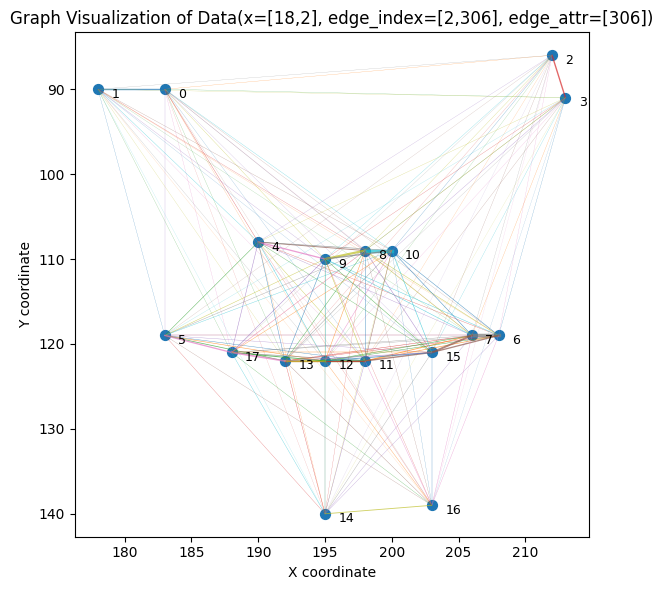

In [138]:
plot_graph(x = data.x , edge_index=data.edge_index , edge_attr= data.edge_attr)

# Define model

In [146]:
import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool

# --- 1) Define your GNN class ---
class GNNFER(torch.nn.Module):
    def __init__(self, hidden1=32, hidden2=16, num_classes=7):
        super().__init__()
        self.conv1 = GCNConv(2,  hidden1)
        self.conv2 = GCNConv(hidden1, hidden2)
        self.lin   = torch.nn.Linear(hidden2, num_classes)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        # two layers of weighted message passing
        x = self.conv1(x, edge_index, edge_weight=edge_attr).relu()
        x = self.conv2(x, edge_index, edge_weight=edge_attr).relu()
        # pool to get graph‐level embedding
        batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        x = global_mean_pool(x, batch)    # shape [1, hidden2]
        return self.lin(x)                # shape [1, num_classes]

# Training and prediction

# MORE TRAINING

In [147]:
def prepare_data(image_path, emotion_label):
    landmarks, _ = detect_landmarks(image_path)
    regions = divide_regions(landmarks)
    nodes = select_nodes_per_region(landmarks, regions)
    data = build_graph(nodes)

    emotion_idx = emotion_map[emotion_label]
    label = torch.tensor([emotion_idx], dtype=torch.long)

    return data, label


In [148]:
def train_model(model, dataset, epochs=500):
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    crit = torch.nn.CrossEntropyLoss()
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for data, label in dataset:
            opt.zero_grad()
            out = model(data)
            loss = crit(out, label)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        if epoch % 100 == 0:
            print(f"Epoch {epoch:4d} – Total Loss: {total_loss:.4f}")

    return model


In [149]:
def predict_emotion(model, image_path):
    landmarks, _ = detect_landmarks(image_path)
    regions = divide_regions(landmarks)
    nodes = select_nodes_per_region(landmarks, regions)
    data = build_graph(nodes)

    model.eval()
    with torch.no_grad():
        out = model(data)
        pred_idx = out.argmax(dim=1).item()
        return idx_to_emotion[pred_idx]


In [150]:
# File paths and labels
images = [
    ('angry.jpg', 'angry'),
    ('happy.jpg', 'happy'),
    ('sad.jpg', 'sad'),
    ('neutral.jpg', 'neutral'),
    ('surprise.jpg', 'surprise')
]

# Prepare training dataset
dataset = [prepare_data(img, label) for img, label in images]

# Initialize and train model
model = GNNFER()
model = train_model(model, dataset)

# Predict on any new image (for example: test_image.jpg)
predicted_emotion = predict_emotion(model, 'neutral.jpg')
print(f"\nPredicted Emotion: {predicted_emotion}")


Epoch    0 – Total Loss: 90.9649
Epoch  100 – Total Loss: 4.5655
Epoch  200 – Total Loss: 3.4421
Epoch  300 – Total Loss: 2.6226
Epoch  400 – Total Loss: 1.9192

Predicted Emotion: neutral


In [121]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, dataset):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for data, label in dataset:
            out = model(data)
            pred = out.argmax(dim=1).item()
            all_preds.append(pred)
            all_labels.append(label.item())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Model Accuracy: {acc * 100:.2f}%")

    return all_labels, all_preds


In [151]:
def plot_confusion_matrix(true_labels, pred_labels, class_names):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


Model Accuracy: 100.00%


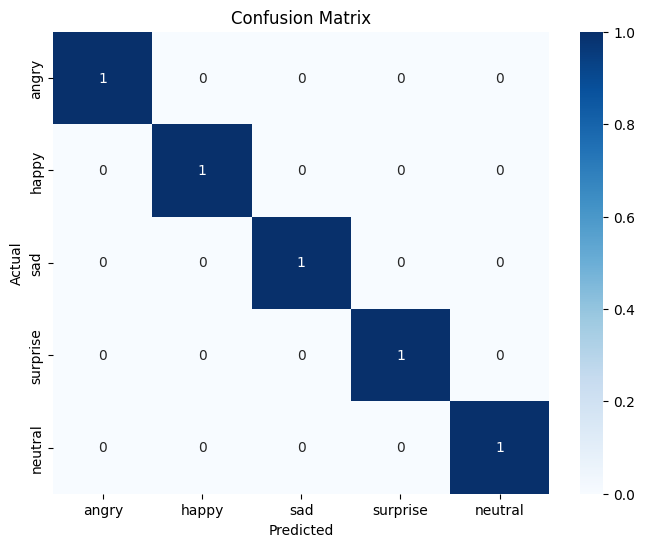

In [152]:
# After training...
true_labels, pred_labels = evaluate_model(model, dataset)

# For your 5-class setup:
class_names = ['angry', 'happy', 'sad', 'surprise', 'neutral']
plot_confusion_matrix(true_labels, pred_labels, class_names)
